### Bước 1: Khai báo thư viện

In [1]:
#Khai báo thư viện
import pandas as pd # Đọc dữ liệu
import numpy as np # Xử lý dữ liệu
import matplotlib.pyplot as plt # Vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler # Chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint # Lưu lại mô hình huấn luyện tốt nhất
# from tensorflow.keras.models import load_model #Tải mô hình

#Các lớp để xây dựng mô hình
from keras.models import Sequential # Đầu vào
from keras.layers import LSTM  # Học phụ thuộc
from keras.layers import Dropout # Tránh học tủ
from keras.layers import Dense  # Đầu ra

#Kiểm tra độ chính xác mô hình
from sklearn.metrics import r2_score # Đo mức độ phù hợp
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error # Đo phần trăm sai số tuyệt đối trung bình

### Bước 2: Đọc dữ liệu

In [2]:
# Load dữ liệu
df = pd.read_csv("BID Historical Data.csv")

### Bước 3: Mô tả dữ liệu

In [3]:
#Định dạng lại cột Date từ obj -> datetime
df['Date'] = pd.to_datetime(df['Date'])
# data.set_index('Date', inplace=True)

In [4]:
# Kích thước dữ liệu
df.shape

(1329, 7)

In [5]:
# Xem dữ liệu 10 dòng đầu
df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,2017-12-01,19516.3,19592.8,19631.1,19439.7,1.65M,-0.58%
1,2017-12-04,19516.3,19669.3,20052.0,19516.3,1.27M,0.00%
2,2017-12-05,19057.0,19669.3,19669.3,19057.0,3.06M,-2.35%
3,2017-12-06,19018.8,18904.0,19057.0,18750.9,2.33M,-0.20%
4,2017-12-07,19133.6,19133.6,19248.4,18789.2,808.64K,0.60%
5,2017-12-08,19133.6,19171.8,19286.7,18865.7,1.07M,0.00%
6,2017-12-11,18368.2,18291.7,18980.5,18291.7,1.56M,-4.00%
7,2017-12-12,18444.8,18368.2,18674.4,17105.4,3.29M,0.42%
8,2017-12-13,18291.7,18444.8,18521.3,18100.4,2.54M,-0.83%
9,2017-12-14,18712.6,18215.2,18750.9,17794.2,1.85M,2.30%


In [6]:
# Xác định kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1329 non-null   datetime64[ns]
 1   Price     1329 non-null   float64       
 2   Open      1329 non-null   float64       
 3   High      1329 non-null   float64       
 4   Low       1329 non-null   float64       
 5   Vol.      1329 non-null   object        
 6   Change %  1329 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 72.8+ KB


In [7]:
# Mô tả bộ dữ liệu
df.describe()

,Price,Open,High,Low
count,1329.000000,1329.000000,1329.000000,1329.000000
mean,31848.289014,31833.519789,32364.304740,31359.551016
std,6471.838843,6478.017596,6569.183256,6392.221642
min,16531.400000,16378.300000,17602.900000,15957.400000
25%,26710.500000,26710.500000,27169.700000,26404.300000
50%,31685.200000,31752.700000,32180.800000,31379.100000
75%,35614.300000,35614.300000,36168.300000,35021.400000
max,49000.000000,49500.000000,49950.000000,48100.000000


### Bước 4: Tiền xử lý dữ liệu

In [5]:
# Lấy dữ liệu
df1 = pd.DataFrame(df, columns=['Date', 'Price'])
# Chuyển cột Date làm index để lập biểu đồ so sánh về sau
df1.index = df1.Date
df1.drop('Date', axis=1, inplace=True)

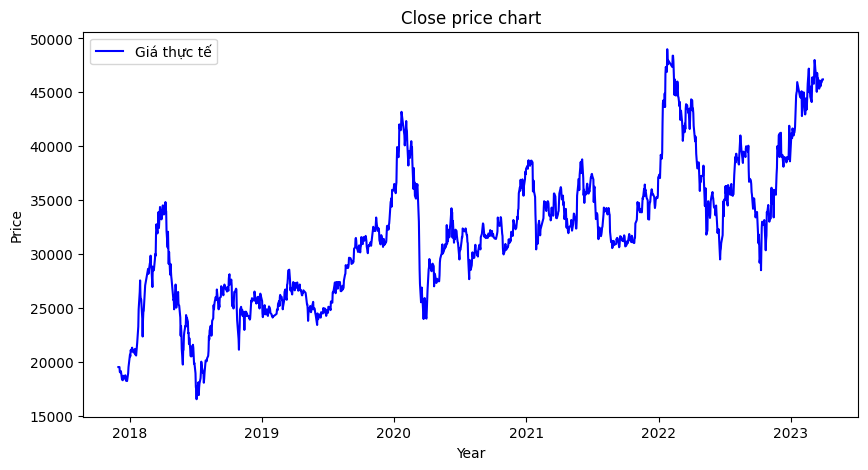

In [6]:
#Lập biểu đồ giá đóng
plt.figure(figsize=(10,5))
plt.plot(df1['Price'], label='Giá thực tế', color='blue')
plt.title('Close price chart')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

In [7]:
df1

,Price
Date,
2017-12-01,19516.3
2017-12-04,19516.3
2017-12-05,19057.0
2017-12-06,19018.8
2017-12-07,19133.6
...,...
2023-03-27,46000.0
2023-03-28,46000.0
2023-03-29,46200.0


In [8]:
#Chia tập dữ liệu
data = df1.values
train_data = data[:930]
test_data = data[930:]

In [9]:
data

array([[19516.3],
       [19516.3],
       [19057. ],
       ...,
       [46200. ],
       [46200. ],
       [46200. ]])

In [10]:
# Chuẩn hóa dữ liệu train, validation và test về khoảng giá trị [0, 1]
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(data)

In [11]:
# Prepare data for LSTM
# Dùng 60 ngày liên tục để làm cơ sở dự đoan giá cho ngày tiếp theo
X_train, y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])

In [15]:
X_train

[array([0.0919319 , 0.0919319 , 0.07778592, 0.0766094 , 0.08014512,
        0.08014512, 0.05657158, 0.05893078, 0.05421546, 0.06717875,
        0.06364303, 0.06482263, 0.05893078, 0.06835835, 0.0612869 ,
        0.05303586, 0.05185933, 0.05893078, 0.06600223, 0.0742502 ,
        0.0919319 , 0.12728913, 0.12257381, 0.14025243, 0.1367167 ,
        0.14732388, 0.1367167 , 0.13789631, 0.14143203, 0.13318098,
        0.13436058, 0.14378815, 0.12728913, 0.12964526, 0.12492993,
        0.16146677, 0.20743118, 0.25693439, 0.30643452, 0.33943564,
        0.29700387, 0.28522018, 0.28522018, 0.22982512, 0.17914539,
        0.2262894 , 0.24986294, 0.25221907, 0.30525492, 0.32529274,
        0.37243367, 0.35829078, 0.36536223, 0.38893577, 0.39011229,
        0.41015011, 0.38186432, 0.38186432, 0.32057742, 0.3783286 ]),
 array([0.0919319 , 0.07778592, 0.0766094 , 0.08014512, 0.08014512,
        0.05657158, 0.05893078, 0.05421546, 0.06717875, 0.06364303,
        0.06482263, 0.05893078, 0.06835835, 0.

In [16]:
y_train

[0.37479287681021045,
 0.3677214293194039,
 0.3688979506353831,
 0.4007194643440124,
 0.41486543922435826,
 0.41015011426424297,
 0.47379314168150144,
 0.49972280911403644,
 0.47379314168150144,
 0.49265136162322976,
 0.5162218266263405,
 0.5350800465680687,
 0.4891156378778265,
 0.5492229415496819,
 0.5303647216079534,
 0.5409718928441634,
 0.5280085990772623,
 0.5138657040956494,
 0.551579064080373,
 0.5539382665097972,
 0.5468668190189907,
 0.5280085990772623,
 0.5280085990772623,
 0.5374361690987599,
 0.5633658365312948,
 0.5397953715281842,
 0.5374361690987599,
 0.480864589172308,
 0.43372057926735363,
 0.47850846664161684,
 0.4384359042274689,
 0.38657656936239937,
 0.42075728550045266,
 0.35593465686848214,
 0.38657656936239937,
 0.35121933190836685,
 0.3417917618868692,
 0.282860979530993,
 0.2852201819604171,
 0.25693439199719115,
 0.3099702481782399,
 0.3276488669052562,
 0.31586209445433433,
 0.2616466370585735,
 0.29229162945122367,
 0.2993630769420301,
 0.3064345244328367,

In [12]:
# Xếp dữ liệu thành 1 mảng
X_train = np.array(X_train)
y_train = np.array(y_train)
# Chuyển dữ liệu từ mảng 2 chiều -> mảng 3 chiều (np.shape) 
# Gồm 3 thông số: số lượng mẫu, số lượng điểm dữ liệu trước đó, số lượng đặc trưng
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

### Bước 5: Xây dựng và huấn luyện mô hình

In [13]:
# Define model
# Lớp Input tạo ra một mô hình neural network tuần tự cho dữ liệu đầu vào
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(LSTM(units=64))
# Lớp Dropout này được sử dụng để ngăn chặn quá trình overfitting trong mô hình.
model.add(Dropout(0.5))
# Lớp Ouput sử dụng để tính giá trị dự đoán
model.add(Dense(1))
# Compile model
model.compile(optimizer='adam', loss='mse')

In [14]:
# Huấn luyện mô hình LSTM
save_model = 'save_model.hdf5'
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.04177, saving model to save_model.hdf5
18/18 - 7s - loss: 0.0418 - 7s/epoch - 381ms/step
Epoch 2/100

Epoch 2: loss improved from 0.04177 to 0.00860, saving model to save_model.hdf5
18/18 - 3s - loss: 0.0086 - 3s/epoch - 145ms/step
Epoch 3/100

Epoch 3: loss improved from 0.00860 to 0.00760, saving model to save_model.hdf5
18/18 - 2s - loss: 0.0076 - 2s/epoch - 119ms/step
Epoch 4/100

Epoch 4: loss improved from 0.00760 to 0.00696, saving model to save_model.hdf5
18/18 - 2s - loss: 0.0070 - 2s/epoch - 110ms/step
Epoch 5/100

Epoch 5: loss improved from 0.00696 to 0.00596, saving model to save_model.hdf5
18/18 - 2s - loss: 0.0060 - 2s/epoch - 115ms/step
Epoch 6/100

Epoch 6: loss improved from 0.00596 to 0.00585, saving model to save_model.hdf5
18/18 - 2s - loss: 0.0059 - 2s/epoch - 106ms/step
Epoch 7/100

Epoch 7: loss improved from 0.00585 to 0.00572, saving model to save_model.hdf5
18/18 - 2s - loss: 0.0057 - 2s/epoch - 107ms/step
Epo

In [15]:
# Dữ liệu train
y_train = scaler.inverse_transform(y_train) # Giá thực
y_train_predict = model.predict(X_train)
y_train_predict = scaler.inverse_transform(y_train_predict) # Giá dự đoán

28/28 [==============================] - 1s 24ms/step


### Bước 6: Sử dụng mô hình

In [16]:
# Xử lý tập test - tương tự tập test
test = df1[len(train_data)-60:].values
test = test.reshape(-1,1)
test_scaled = scaler.transform(test)

X_test = []
for i in range(60, test.shape[0]):
    X_test.append(test_scaled[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

#Dữ liệu test
y_test = data[930:] #Giá thực
y_test_predict = model.predict(X_test)
y_test_predict = scaler.inverse_transform(y_test_predict) #Giá dự đoán

13/13 [==============================] - 0s 26ms/step


C:\Users\Administrator\AppData\Local\Temp\ipykernel_13224\1208346432.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #Thêm dữ liệu
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13224\1208346432.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #Thêm dữ liệu


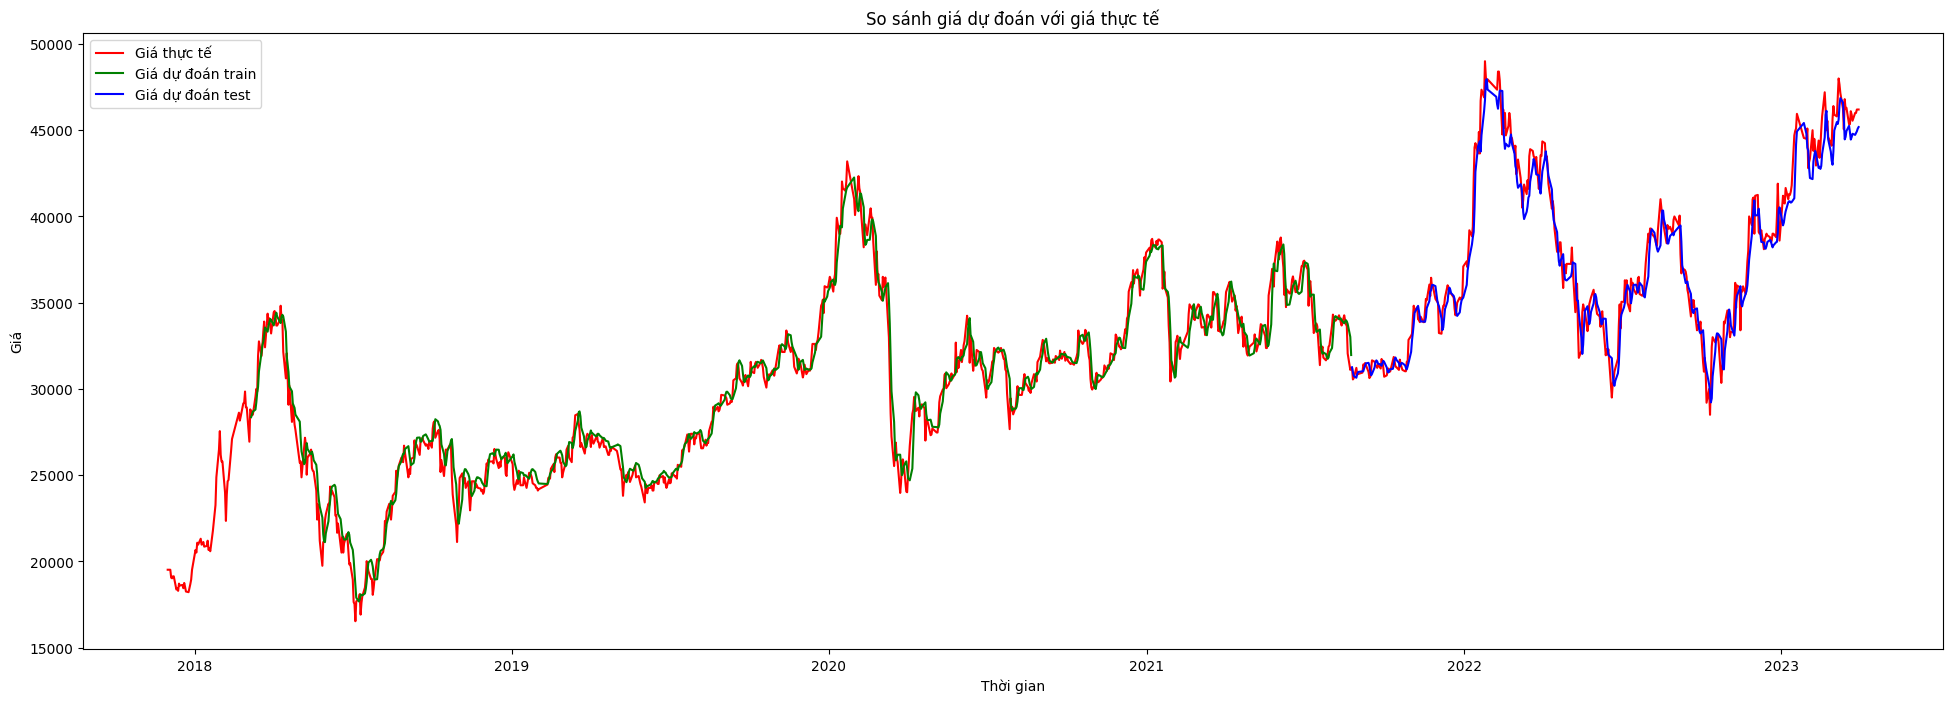

In [17]:
#Lập biểu đồ so sánh
train_data1 = df1[60:930]
test_data1 = df1[930:]

plt.figure(figsize=(24,8))
plt.plot(df1, label='Giá thực tế', color='red')
train_data1['Dự đoán'] = y_train_predict #Thêm dữ liệu
plt.plot(train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
test_data1['Dự đoán'] = y_test_predict #Thêm dữ liệu
plt.plot(test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.title('So sánh giá dự đoán với giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend()
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_13224\1014500415.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #Thêm dữ liệu
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13224\1014500415.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #Thêm dữ liệu


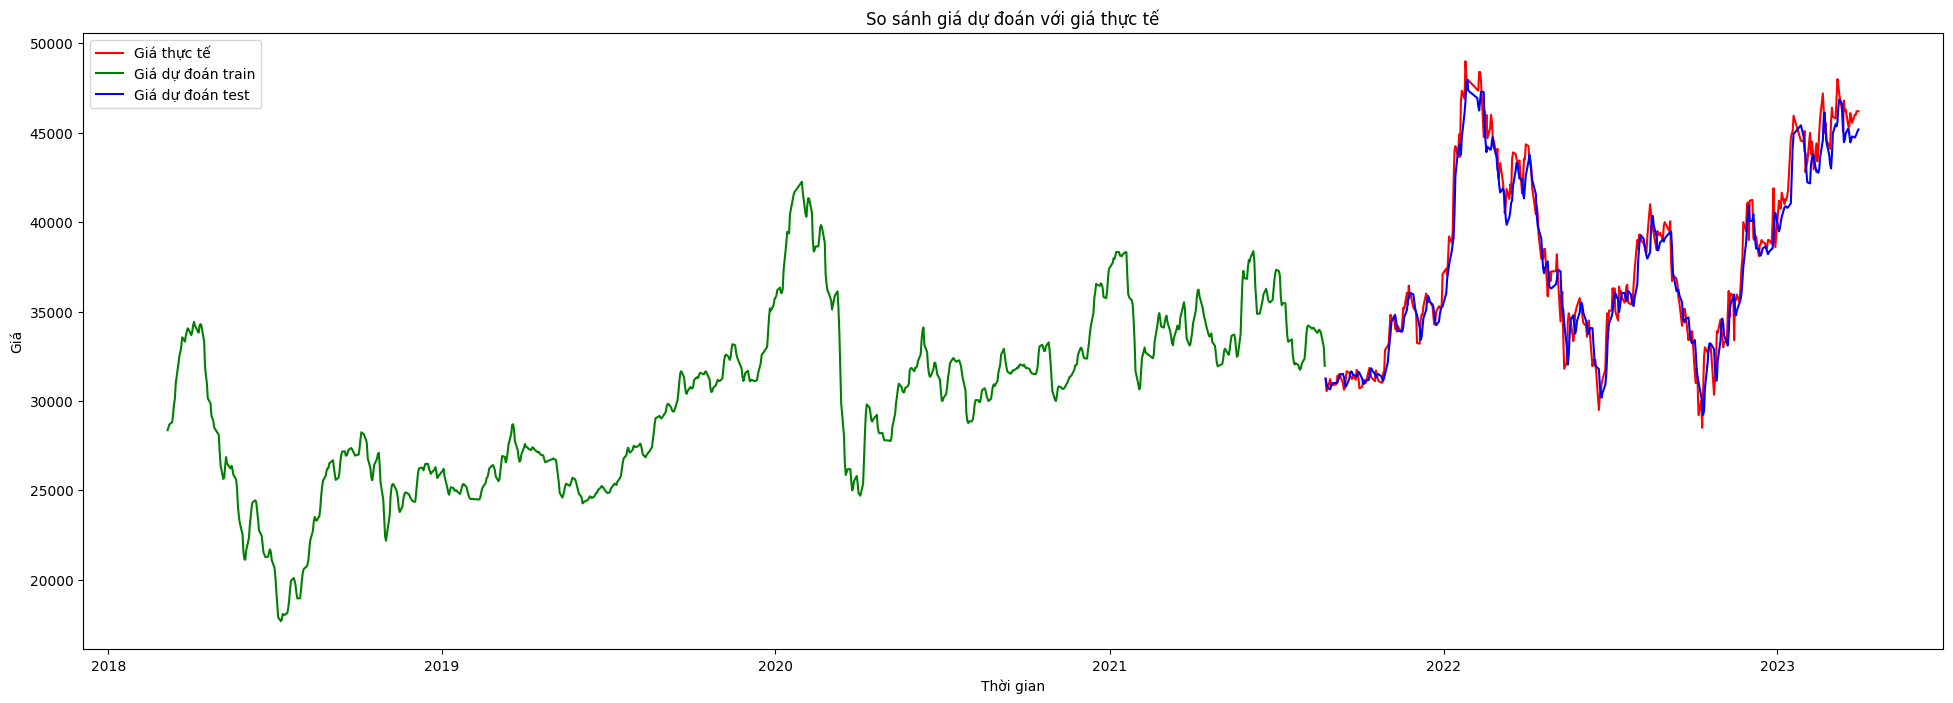

In [18]:
#Lập biểu đồ so sánh
train_data1 = df1[60:930]
# Lấy 60 dòng đầu đi train
test_data1 = df1[930:]
data_origin = df1[930:]

plt.figure(figsize=(24,8))
plt.plot(data_origin, label='Giá thực tế', color='red')
train_data1['Dự đoán'] = y_train_predict #Thêm dữ liệu
plt.plot(train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
test_data1['Dự đoán'] = y_test_predict #Thêm dữ liệu
plt.plot(test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.title('So sánh giá dự đoán với giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend()
plt.show()

### Độ chính xác của mô hình

In [19]:
#R2
print('\n\nĐộ phù hợp tập test', r2_score(y_test, y_test_predict))
#mse
mse_test = mean_squared_error(y_test, y_test_predict)
print('Mức độ sai khác giữa giá trị dự đoán và giá trị thực tế', mse_test)
#mae
mae_test = mean_absolute_error(y_test, y_test_predict)
print('Sai số tuyệt đối trung bình tập test:', mae_test)
#rmse
rmse_test = np.sqrt(mse_test)
print('RMSE: ', rmse_test)
#mape
#CT: mape_test = np.mean(np.abs((y_test - y_test_predict) / y_test)) * 100
mape_test = mean_absolute_percentage_error(y_test, y_test_predict)
print('Phẩn trăm Sai số tuyệt đối trung bình tập test:', mape_test)



Độ phù hợp tập test 0.9525582110559973
Mức độ sai khác giữa giá trị dự đoán và giá trị thực tế 1237259.5201172442
Sai số tuyệt đối trung bình tập test: 844.1224663220552
RMSE:  1112.3216801434935
Phẩn trăm Sai số tuyệt đối trung bình tập test: 0.022004591343206113


In [20]:
#Bảng dữ liệu dữ đoán giá cụ thể ở tập test
test_data1

,Price,Dự đoán
Date,,
2021-08-25,31221.9,31254.417969
2021-08-26,30549.2,30982.376953
2021-08-27,30628.3,30746.416016
2021-08-30,31221.9,30648.851562
2021-08-31,30826.2,30869.212891
...,...,...
2023-03-27,46000.0,44730.292969
2023-03-28,46000.0,44829.613281
2023-03-29,46200.0,44935.753906


### Dự đoán 30 ngày kế tiếp

In [21]:
# Lấy giá trị cuối cùng trong tập data
last_day = data[-1]

# Thực hiện dự đoán cho 30 ngày tiếp theo
for i in range(30):
    # Lấy 60 ngày cuối cùng từ tập data để dự đoán tiếp theo
    last_60_days = data[-60:]

    # Chuẩn hóa dữ liệu
    last_60_days_scaled = scaler.transform(last_60_days)

    # Tạo một danh sách trống để lưu dữ liệu dự đoán
    X_pred = []

    # Thêm các giá trị chuẩn hóa vào danh sách dự đoán
    for j in range(60):
        X_pred.append(last_60_days_scaled[j, 0])

    # Chuyển danh sách dự đoán thành mảng numpy
    X_pred = np.array(X_pred)

    # Thay đổi hình dạng của mảng dự đoán để phù hợp với mô hình
    X_pred = np.reshape(X_pred, (1, X_pred.shape[0], 1))

    # Dự đoán giá tiếp theo
    y_pred = model.predict(X_pred)

    # Đưa giá dự đoán về lại đơn vị gốc
    y_pred = scaler.inverse_transform(y_pred)

    # In kết quả dự đoán
    print("Ngày", i+1, ":", y_pred[0][0])

    # Thêm giá dự đoán mới vào tập dữ liệu
    last_day = y_pred[0][0]
    data = np.append(data, last_day)
    data = data.reshape(-1, 1)

# In tập dữ liệu hoàn chỉnh với giá thực và giá dự đoán
# print("\nTập dữ liệu hoàn chỉnh:")
# print(np.concatenate((y_test, y_test_predict), axis=1))

1/1 [==============================] - 0s 40ms/step
Ngày 1 : 45196.324
1/1 [==============================] - 0s 37ms/step
Ngày 2 : 44650.89
1/1 [==============================] - 0s 32ms/step
Ngày 3 : 43895.62
1/1 [==============================] - 0s 26ms/step
Ngày 4 : 43072.33
1/1 [==============================] - 0s 26ms/step
Ngày 5 : 42247.92
1/1 [==============================] - 0s 25ms/step
Ngày 6 : 41454.973
1/1 [==============================] - 0s 25ms/step
Ngày 7 : 40708.613
1/1 [==============================] - 0s 28ms/step
Ngày 8 : 40014.387
1/1 [==============================] - 0s 26ms/step
Ngày 9 : 39372.414
1/1 [==============================] - 0s 27ms/step
Ngày 10 : 38779.95
1/1 [==============================] - 0s 29ms/step
Ngày 11 : 38232.96
1/1 [==============================] - 0s 28ms/step
Ngày 12 : 37727.18
1/1 [==============================] - 0s 31ms/step
Ngày 13 : 37258.66
1/1 [==============================] - 0s 27ms/step
Ngày 14 : 36824.043
1/1 [====

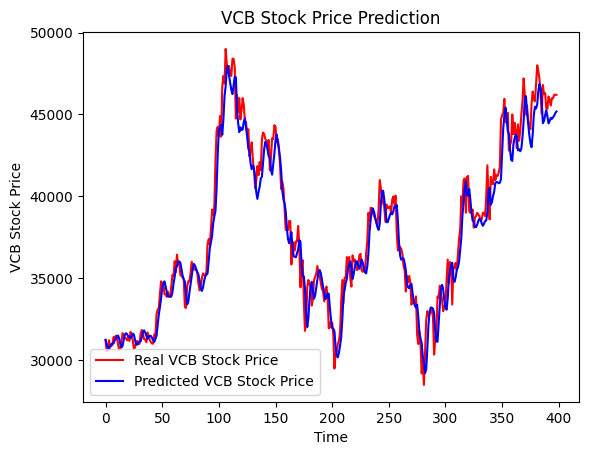

In [22]:
# Ve bieu do gia that va gia du doan
plt.plot(y_test, color = 'red', label = 'Real VCB Stock Price')
plt.plot(y_test_predict, color = 'blue', label = 'Predicted VCB Stock Price')
plt.title('VCB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('VCB Stock Price')
plt.legend()
plt.show()